In [1]:
import time
import toml
import torch as np
from torchvision.utils import save_image
from torch.utils import data

from tools.celeba import CelebALoader
from dataset import Split

from models.models import create_model
from tools.toml import load_option
from tools.mask import mask_iter

## 数据载入

In [2]:
header_opt = load_option('options/header.toml')
loader = CelebALoader(header_opt.data_root)
dataset = Split(loader, header_opt.fine_size)
train_data = dataset.train('bbox')
trainset = data.DataLoader(train_data,
                           batch_size=header_opt.batch_size,
                           shuffle=True)
maskset = mask_iter(header_opt.mask_root, header_opt.fine_size)
print('训练集数量：', len(trainset))
print('掩码数量：', len(maskset))

训练集数量： 162770
掩码数量： 12000


In [4]:
for batch in maskset:
    break

In [10]:
 batch.shape

torch.Size([3, 256, 256])

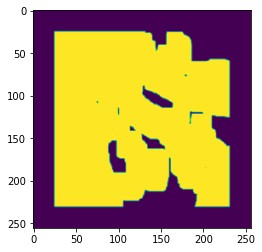

In [9]:
from matplotlib import pyplot as plt
plt.imshow(batch[1])

## 模型载入

In [3]:
def mask_op(mask):
    mask = mask.cuda()
    mask = mask[0][0]
    mask = np.unsqueeze(mask, 0)
    mask = np.unsqueeze(mask, 1)
    mask = mask.byte()
    return mask

In [4]:
model_opt = load_option('options/train2.toml')
model = create_model(model_opt)

csa_net
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
---------- Networks initialized -------------
UnetGeneratorCSA(
  (model): UnetSkipConnectionBlock_3(
    (model): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): UnetSkipConnectionBlock_3(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), dilation=(2, 2))
          (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (3): LeakyReLU(negative_slope=0.2, inplace=True)
          (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (6): UnetSkipConnectionBlock_3(
            (model): Sequential(
              (0): LeakyRe

In [11]:
for batch, mask in zip(trainset, maskset):
    break

In [13]:
img, bbox = batch

In [23]:
x,y,w,h = bbox[0]

In [28]:
torch

NameError: name 'torch' is not defined

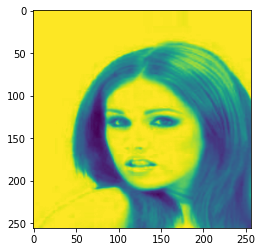

In [27]:
plt.imshow(img[0, 0])

In [24]:
x, y, w, h

(tensor(766), tensor(38), tensor(151), tensor(209))

In [15]:
img[bbox]

IndexError: index 209 is out of bounds for dimension 0 with size 1

In [ ]:
opt = load_option('options/train.toml')
total_steps = 0
iter_start_time = time.time()
# 载入已经训练的模型
load_epoch = 9
model.load(load_epoch)
start_epoch = load_epoch + 1
for epoch in range(start_epoch, opt.epochs):
    epoch_start_time = time.time()
    epoch_iter = 0
    trainset = data.DataLoader(train_data,
                               batch_size=opt.batch_size,
                               shuffle=True)
    for batch, mask in zip(trainset, maskset):
        image = batch[0]
        mask = mask_op(mask)
        total_steps += header_opt.batch_size
        epoch_iter += header_opt.batch_size
        # it not only sets the input data with mask, but also sets the latent mask.
        model.set_input(image, mask)
        model.set_gt_latent()
        model.optimize_parameters()
        if total_steps % opt.display_freq == 0:
            real_A, real_B, fake_B = model.get_current_visuals()
            # real_A=input, real_B=ground truth fake_b=output
            pic = (np.cat([real_A, real_B, fake_B], dim=0) + 1) / 2.0
            save_image_path = f"{opt.save_dir}/epoch{epoch}-{total_steps}.jpg"
            save_image(pic, save_image_path, nrow=3)
        if total_steps % 100 == 0:
            errors = model.get_current_errors()
            t = (time.time() - iter_start_time) / opt.batch_size
            print(f"Epoch/total_steps: {epoch}/{total_steps}", dict(errors))
    if epoch % opt.save_epoch_freq == 0:
        print(f'保存模型 Epoch {epoch}, iters {total_steps}')
        model.save(epoch)
    print(f'Epoch/Epochs {epoch}/{opt.epochs-1} 花费时间：{time.time() - epoch_start_time}s')
    model.update_learning_rate()

Epoch/total_steps: 10/100 {'G_GAN': 5.117822170257568, 'G_L1': 5.307808876037598, 'D': 1.04343843460083, 'F': 0.1525660753250122}
Epoch/total_steps: 10/200 {'G_GAN': 5.265392303466797, 'G_L1': 9.157577514648438, 'D': 1.1211493015289307, 'F': 0.15904486179351807}
Epoch/total_steps: 10/300 {'G_GAN': 4.9373321533203125, 'G_L1': 7.775383949279785, 'D': 1.02850341796875, 'F': 0.07974669337272644}
Epoch/total_steps: 10/400 {'G_GAN': 5.332225799560547, 'G_L1': 5.683181285858154, 'D': 1.0330677032470703, 'F': 0.04828757792711258}
Epoch/total_steps: 10/500 {'G_GAN': 4.983488082885742, 'G_L1': 12.851926803588867, 'D': 1.3944638967514038, 'F': 0.18080826103687286}
Epoch/total_steps: 10/600 {'G_GAN': 5.054282188415527, 'G_L1': 6.166619777679443, 'D': 1.0029690265655518, 'F': 0.034665804356336594}
Epoch/total_steps: 10/700 {'G_GAN': 4.989170074462891, 'G_L1': 5.69755744934082, 'D': 1.0157641172409058, 'F': 0.020558014512062073}
Epoch/total_steps: 10/800 {'G_GAN': 5.2013654708862305, 'G_L1': 6.99295